In [21]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys
import platform
from scipy.spatial import KDTree
from sympy import flatten


from lib.utils import *
from lib.plot_utils import *
from lib.event_processing import *

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


        recno  TYC1  TYC2  TYC3  BTmag  VTmag       HIP    RA(ICRS)  DE(ICRS)
0        9734    58  1618     1  4.687  2.716   14135.0   45.569912  4.089921
1        9659    58   607     1  5.487  5.591   14143.0   45.593785  4.352873
2       10433    62  1579     1  6.849  5.680   14915.0   48.109873  6.660885
3      134397   641   985     1  4.567  4.681   13954.0   44.928738  8.907399
4      135691   650  1471     1  4.721  3.705   15900.0   51.203480  9.029056
...       ...   ...   ...   ...    ...    ...       ...         ...       ...
4561  1314384  5204  1584     1  6.707  5.797  103981.0  316.019636 -5.823050
4562  1314058  5202  1366     1  7.014  5.951  105412.0  320.268022 -4.560152
4563  1314057  5202  1365     1  5.648  5.791  105164.0  319.546110 -4.519507
4564  1311170  5186  2126     1  5.440  5.539  103005.0  313.036222 -5.507044
4565  1311169  5186  2125     1  6.561  4.638  102624.0  311.934324 -5.027601

[4566 rows x 9 columns]
Data shape:  (4566, 3)
Star ID (HIP):  

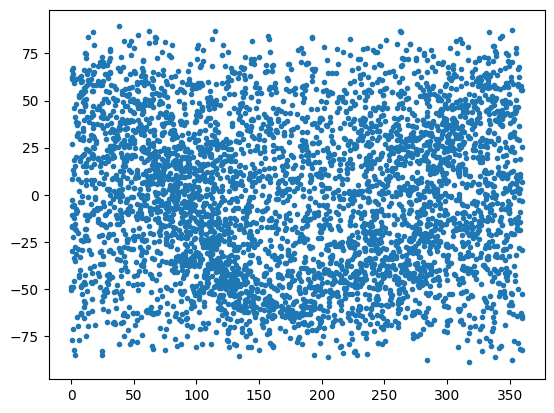

In [22]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values

print("Data shape: ", stars_data.shape)

for i in range(5):
    print("Star ID (HIP): ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
plt.show()

In [24]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,1:3])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,1:3], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []


feature_type_1 = 'permutation_angle_dist'
feature_type_2 = 'permutation'

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    # print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    # features_3 = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        # print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")


    # features_1, features_2 = get_star_features(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], 1, 1, 1)
        
    features_1 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_1)
    features_2 = get_star_features_2(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], feature_type_2)
    
    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)
    # print('features_1: ', features_1)
    # print('features_2: ', features_2)

    # print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )
    # print('----------------------')

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

print("Features 1 shape: ", features_1_n.shape)
print("Features 2 shape: ", features_2_n.shape)

# Print example of the features
print("Example of the features: ")
print("Features 1: ", features_vec_1[0])
print("Features 2: ", features_vec_2[0])

norm_param = [features_vec_1.min(axis=0), features_vec_1.max(axis=0), features_vec_2.min(axis=0), features_vec_2.max(axis=0)]
print("Normalization parameters: ", norm_param)

Features 1 shape:  (4566, 10)
Features 2 shape:  (4566, 10)
Example of the features: 
Features 1:  [ 1.26813  19.84728  0.72330  0.41477  2.35176  7.17937  7.42159  3.56360
  3.24397  3.31589]
Features 2:  [ 0.26403  3.61404  4.33014  4.72649  3.41433  4.35828  4.73313  3.71788
  3.68960  0.53448]
Normalization parameters:  [array([ 0.00003,  0.00052,  0.00229,  0.00613,  0.00000,  0.00002,
        0.00504,  0.00000,  0.00052,  0.00000]), array([ 63.64720,  86.46494,  70.37681,  75.46900,  72.56896,  78.46716,
        89.23944,  110.06150,  103.03969,  83.68361]), array([ 0.00023,  0.05827,  0.20457,  0.34824,  0.00025,  0.00834,
        0.08353,  0.00025,  0.05827,  0.00023]), array([ 14.69526,  14.78413,  15.98960,  16.79413,  16.55092,  19.48184,
        17.41623,  26.10863,  23.40929,  20.64279])]


Star ID: 12828.0 ( 41.234935 , 10.114216 )
Neighbor ID: 12832.0 ( 41.239628 , 12.445956 )
Neighbor ID: 12153.0 ( 39.157316 , 12.447840 )
Neighbor ID: 12148.0 ( 39.146259 , 7.730073 )
Neighbor ID: 13954.0 ( 44.928738 , 8.907399 )
features_1:  [10.99278016 12.45088016  7.25924217  1.2271102  11.56463221 19.9110787
  9.6335969  21.64732955 17.69897239 25.42634189]
features_2:  [2.33174444 3.12446767 3.16965397 3.88594822 2.0823128  5.15962682
 5.11184133 4.71778018 6.77082253 5.90111532]
----------------------


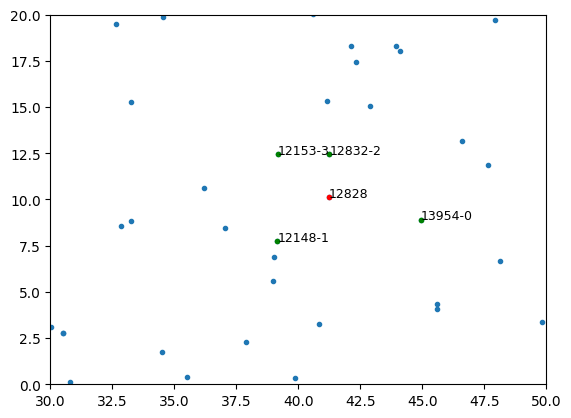

In [4]:
# Search the neighbors of a specific star

stars_sublist = [12828]

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):

    if stars_data[i][0] in stars_sublist:
        print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

        neihgtbors_list = []
        for j in range(1,n_of_neighbor+1):
            neighbor_index = indices[i][j]
            print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")
            neihgtbors_list.append(stars_data[neighbor_index][0])

        # features_vec_3.append(features_3)
        print('features_1: ', features_vec_1[i])
        print('features_2: ', features_vec_2[i])
        print('----------------------')

        plt.figure()
        plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

        plt.plot(stars_data[i,1],stars_data[i,2],'.r')
        plt.text(stars_data[i,1], stars_data[i,2], int(stars_data[i,0]), fontsize=9)

        stars_subdata = stars_data[np.where(np.isin(stars_data[:,0], neihgtbors_list))]
        plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
        #Plot the identification names of the sub set of stars
        for i in range(len(stars_subdata)):
            plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) + '-' + str(i), fontsize=9)

        #change the limits of the axis
        plt.xlim([30, 50])
        plt.ylim([0, 20])

        plt.show()  

In [8]:

## SINGLE TRAINING ##

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
# mesh_size = int(np.sqrt(features_1_n.shape[0])/2)
# Manual set 

hyperparameters_1 = {'mesh_size_1': 59, 'sigma_1': 3, 'learning_rate_1': 1.12, 'neighborhood_function_1': 'triangle', 
 'topology_1': 'rectangular', 'activation_distance_1': 'euclidean'}
 
hyperparameters_2 = {'mesh_size_2': 62, 'sigma_2': 3, 'learning_rate_2': 1.07,'neighborhood_function_2': 'triangle',
 'topology_2': 'rectangular', 'activation_distance_2': 'manhattan'}


# hyperparameters = {'mesh_size_1': 60, 'mesh_size_2': 60, 'sigma': 3.263122498850444, 'learning_rate': 0.7894422310231358, 'neighborhood_function': 'triangle', 'topology': 'rectangular', 'activation_distance': 'euclidean'}

# Initialize the SOM
som1 = MiniSom(
    x = hyperparameters_1['mesh_size_1'],
    y = hyperparameters_1['mesh_size_1'],
    input_len = features_1_n.shape[1],

    sigma=hyperparameters_1['sigma_1'],
    learning_rate=hyperparameters_1['learning_rate_1'],
    neighborhood_function=hyperparameters_1['neighborhood_function_1'],
    topology=hyperparameters_1['topology_1'],
    activation_distance=hyperparameters_1['activation_distance_1']

)

som2 = MiniSom(
    x = hyperparameters_2['mesh_size_2'],
    y = hyperparameters_2['mesh_size_2'],
    input_len = features_2_n.shape[1],

    sigma=hyperparameters_2['sigma_2'],
    learning_rate=hyperparameters_2['learning_rate_2'],
    neighborhood_function=hyperparameters_2['neighborhood_function_2'],
    topology=hyperparameters_2['topology_2'],
    activation_distance=hyperparameters_2['activation_distance_2']
)

print(f"SOM 1 size = {hyperparameters_1['mesh_size_1']} x {hyperparameters_1['mesh_size_1']} = {hyperparameters_1['mesh_size_1']**2}")
print(f"SOM 2 size = {hyperparameters_2['mesh_size_2']} x {hyperparameters_2['mesh_size_2']} = {hyperparameters_2['mesh_size_2']**2}")

# Train the SOM
# som1.train_random(data=features_1_n, num_iteration=10000, verbose= True)
# # print(som1.topographic_error(features_1_n))
# som2.train_random(data=features_2_n, num_iteration=10000, verbose= True)
# print(som2.topographic_error(features_2_n))

SOM 1 size = 59 x 59 = 3481
SOM 2 size = 62 x 62 = 3844


In [15]:
#Quick train 
som1.train(data=features_1_n, num_iteration=500_000, verbose= True)
som2.train(data=features_2_n, num_iteration=500_000, verbose= True)


 [    524 / 500000 ]   0% - 0:03:11 left 

/home/ignaciozm/.local/lib/python3.10/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/ignaciozm/.local/lib/python3.10/site-packages/numpy/linalg/linalg.py:2547: RuntimeWarning: overflow encountered in reduce
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


 [ 500000 / 500000 ] 100% - 0:00:00 left 

/home/ignaciozm/.local/lib/python3.10/site-packages/minisom.py:534: RuntimeWarning: overflow encountered in power
  weights_flat_sq = power(weights_flat, 2).sum(axis=1, keepdims=True)



 quantization error: 0.0344793760636491
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 0.020931912150037976


In [23]:
# Train more 

total_steps = 2_000_000
points = 100
top_error_1= []
quan_error_1 = []
for i in range(points):
    som1.train(data=features_1_n, num_iteration=total_steps//points, verbose= False)
    top_error_1.append(som1.topographic_error(features_1_n))
    quan_error_1.append(som1.quantization_error(features_1_n))
    print('\r', f'Training 1: {i*(total_steps//points)} / {total_steps} ={ (i*(total_steps//points)) / total_steps}', end='', flush=True)
print('quantization error:', som1.quantization_error(features_1_n))

total_steps = 2_000_000
n_points = 100
top_error_2 = []
quan_error_2 = []
for i in range(n_points):
    som2.train(data=features_2_n, num_iteration=total_steps//n_points, verbose= False)
    top_error_2.append(som2.topographic_error(features_2_n))
    quan_error_2.append(som2.quantization_error(features_2_n))
    print('\r', f'Training 2: {i*(total_steps//points)} / {total_steps} ={ (i*(total_steps//points)) / total_steps}', end='', flush=True)
print('quantization error:', som2.quantization_error(features_2_n))



ValueError: Received 0 features, expected 10.

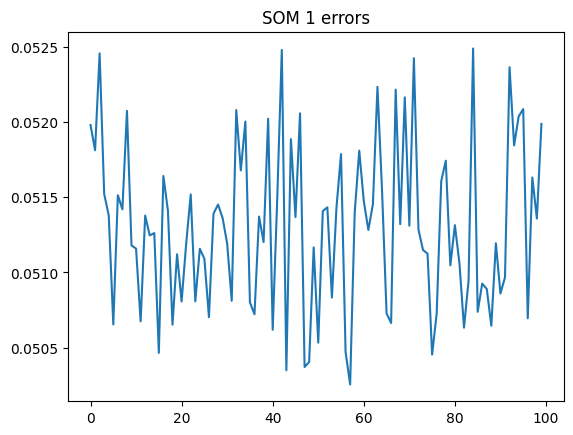

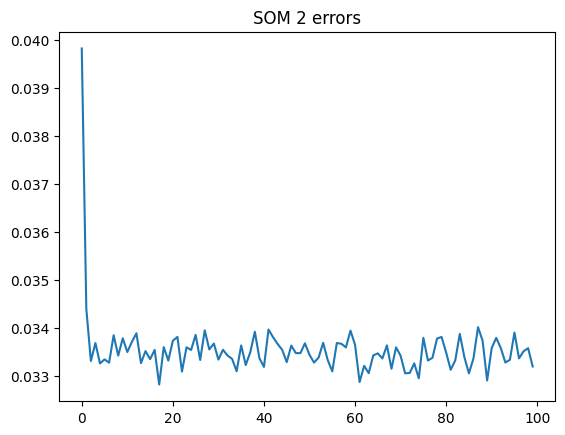

In [64]:
# Plot the errors in the same plot
plt.figure()
# plt.plot(top_error, label='topographic error')
plt.plot(quan_error_1, label='quantization error')
plt.title('SOM 1 errors')
plt.show()

# Plot the errors in the same plot
plt.figure()
# plt.plot(top_error, label='topographic error')
plt.plot(quan_error_2, label='quantization error')
plt.title('SOM 2 errors')
plt.show()

In [25]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
def add_values_in_dict(sample_dict, key, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    if key not in sample_dict:
        sample_dict[key] = list()
    sample_dict[key].extend(list_of_values)
    return sample_dict

star_dict_1= {}
star_dict_2= {}

for i in range(len(features_1_n)):
    star_dict_1 = add_values_in_dict(star_dict_1, som1.winner(features_1_n[i]),[i])
    star_dict_2 = add_values_in_dict(star_dict_2, som2.winner(features_2_n[i]),[i])


print("Number of neurons with data:",len(star_dict_1),"; Total neurons:", som1._xx.shape[0]*som1._xx.shape[1])
print("Number of neurons with data:",len(star_dict_2),"; Total neurons:", som2._xx.shape[0]*som2._xx.shape[1])
star_dict_2

/home/ignaciozm/.local/lib/python3.10/site-packages/numpy/linalg/linalg.py:2546: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


Number of neurons with data: 2806 ; Total neurons: 3481
Number of neurons with data: 3117 ; Total neurons: 3844


{(50, 21): [0],
 (28, 49): [1, 801, 3779],
 (52, 61): [2, 3983],
 (52, 36): [3, 2447],
 (10, 7): [4, 4504],
 (0, 37): [5, 1058],
 (5, 50): [6, 1054, 4121],
 (46, 22): [7, 4360],
 (48, 31): [8, 1258, 1259, 2821],
 (21, 38): [9, 1611],
 (15, 33): [10],
 (15, 6): [11, 2750],
 (50, 12): [12, 4491],
 (29, 15): [13, 379],
 (50, 7): [14],
 (19, 5): [15, 2230],
 (52, 12): [16, 1667],
 (46, 4): [17],
 (8, 61): [18, 19, 2207],
 (12, 27): [20, 21],
 (34, 35): [22],
 (17, 48): [23, 1104],
 (35, 11): [24],
 (6, 14): [25, 1301],
 (27, 0): [26],
 (4, 27): [27, 3304, 3311],
 (2, 22): [28],
 (3, 24): [29, 30, 3606],
 (43, 27): [31, 2696, 3040],
 (14, 27): [32, 33],
 (46, 25): [34],
 (2, 5): [35, 1077, 4486],
 (0, 53): [36, 4503],
 (12, 6): [37, 38],
 (1, 24): [39, 2138],
 (0, 27): [40, 1879, 3282, 3283],
 (0, 26): [41, 42, 43, 44, 50],
 (2, 42): [45, 3661],
 (7, 10): [46],
 (2, 27): [47, 48],
 (0, 24): [49, 2133, 2135, 2136],
 (5, 29): [51],
 (41, 7): [52, 1453],
 (1, 26): [53, 1883],
 (38, 55): [54],


83

In [14]:
# ---------------------------------------------------------------------------- #
# --------------------------------- SAVE SOM --------------------------------- #    
# ---------------------------------------------------------------------------- #


import pickle

mesh_size_1 = hyperparameters_1['mesh_size_1']
mesh_size_2 = hyperparameters_2['mesh_size_2']

name = f'acc{int(cont[0] / stars_pos.shape[0] *100)}_n{str(mesh_size_1)}_{str(mesh_size_2)}_tycho{catalog_path[-5:-4]}_permutation_multi_permutation'

print(name)

# Create a directory to save the SOM parameters
if not os.path.exists(f'../data/SOM_parameters/{name}'):
    os.makedirs(f'../data/SOM_parameters/{name}')

# saving the som in the file som.p
with open(f'../data/SOM_parameters/{name}/som1_{name}.p', 'wb') as outfile:
    pickle.dump([som1, som2], outfile)

# Save normalization parameters
with open(f'../data/SOM_parameters/{name}/normalization_parameters_tycho{catalog_path[-5:-4]}.p', 'wb') as outfile:
    pickle.dump([features_vec_1.min(axis=0), features_vec_1.max(axis=0), features_vec_2.min(axis=0), features_vec_2.max(axis=0)], outfile)

# Save dictionario of neurons to star
with open(f'../data/SOM_parameters/{name}/star_dict_{name}.p', 'wb') as outfile:
    pickle.dump([star_dict_1, star_dict_2], outfile)

with open(f'../data/SOM_parameters/{name}/index_{name}.p', 'wb') as outfile:
    pickle.dump(indices, outfile)


acc84_n59_62_tycho6_permutation_multi_permutation


In [48]:
## For optuna training 
# with open('../training_optuna/features/norm_features_'+ 'tycho' + catalog_path[-5:-4] + '.p', 'wb') as outfile:
#     pickle.dump([features_1_n,features_1_n], outfile)


In [17]:
# ---------------------------------------------------------------------------- #
# --------------------------------- LOAD SOM --------------------------------- #    
# ---------------------------------------------------------------------------- #
import pickle

mesh_size = 80
catalog_filter = 6
name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)

name = 'n80_tycho6'

#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(name[-1]) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)



SOM1: Predicted Stars ID: [1274]
SOM2: Predicted Stars ID: [1274, 1637, 3521]
Final guess: 1274, actual star ID: 1274


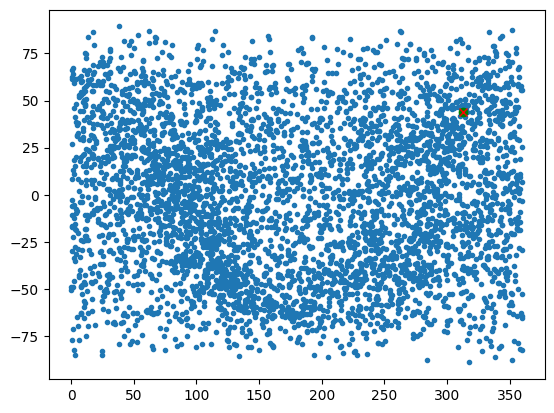

In [59]:
from lib.event_processing import predict_star_id
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))
# random_id = np.where(stars_data[:,0] == 12828)[0][0] # To check the prediction of a specific star (not that random)

sample_feature_1= features_vec_1[random_id] 
sample_feature_2= features_vec_2[random_id] 

predicted_star_ids_1 = predict_star_id(sample_feature_1, [features_vec_1.min(), features_vec_1.max()], star_dict_1, som1)
predicted_star_ids_2 = predict_star_id(sample_feature_2, [features_vec_2.min(), features_vec_2.max()], star_dict_2, som2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
else:
    star_guess = None

print(f"SOM1: Predicted Stars ID: {predicted_star_ids_1}")
print(f"SOM2: Predicted Stars ID: {predicted_star_ids_2}" )
print(f"Final guess: {star_guess}, actual star ID: {random_id}")

if star_guess is not None:
    plt.figure()
    plt.plot(stars_data[:,1],stars_data[:,2],'.')
    plt.plot(stars_data[random_id][1],stars_data[random_id][2],'og')
    plt.plot(stars_data[star_guess][1],stars_data[star_guess][2],'xr')
    plt.show()


Normal star check

In [26]:
import time 
from lib.event_processing import predict_star_id


cont = np.zeros(6) # [Correct match, wrong match, multiple match, no macht(match 2 bad), no macht(match 1 bad), no macht(both mach bad)]
cont_no_match = np.zeros(3) # [no match 1, no match 2, no match both]
acc = np.zeros(2) # [correct SOM1, correct SOM2]

stars_pos = np.copy(stars_data[:,1:3])
noise= np.random.normal(loc=1, scale=0.001, size=stars_pos.shape)
mean_noise = np.mean(np.abs(1-noise), axis=0)
mean_time = 0
stars_pos *= noise

time_start = time.time()

som1_activate_data = []
som2_activate_data = []

for i in range(len(stars_pos)):
    features_1 = []
    features_2 = []
        
    # features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)
    # feature_type_1 = 'permutation_multi'
    # feature_type_2 = 'permutation'

    features_1 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_1)
    features_2 = get_star_features_2(stars_pos[indices[i][0:n_of_neighbor+1]], feature_type_2)

    winner_ids_1 = predict_star_id(features_1, norm_param[0:2], star_dict_1, som1)
    winner_ids_2 = predict_star_id(features_2, norm_param[2:4], star_dict_2, som2)

    if i in winner_ids_1 and len(winner_ids_1) < 20:
        acc[0] += 1
    if i in winner_ids_2 and len(winner_ids_2) < 20:
        acc[1] += 1
    

    if winner_ids_1[0] == 0: # If no match of SOM1 (id returned is 0) use directly the SOM2 result
        star_guess = winner_ids_2
    elif winner_ids_2[0] == 0: # If no match of SOM2 (id returned is 0) use directly the SOM1 result
        star_guess = winner_ids_1
    else:
        star_guess = list(set(winner_ids_1).intersection(winner_ids_2))

    if len(star_guess) == 0: # Second guees 
        if len(winner_ids_1) == 1 and len(winner_ids_2) != 1:
            star_guess = (winner_ids_1)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) != 1:
            star_guess = (winner_ids_2)
        elif len(winner_ids_2) == 1 and len(winner_ids_1) == 1:
            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            if act_som1.min() < act_som2.min():
                star_guess = winner_ids_1
            else:
                star_guess = winner_ids_2

    # Accuracy count
    if len(star_guess) == 1:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
    else:
        # print("Error: ", list(set(winner_ids_1).intersection(winner_ids_2)), "!=", i)
        if len(star_guess) == 0: # If no match

            act_som1 = som1.activate( (features_1 - norm_param[0])/(norm_param[1]-norm_param[0]) )
            act_som2 = som2.activate( (features_2 - norm_param[2])/(norm_param[3]-norm_param[2]) )
            som1_activate_data.append([act_som1.min(), act_som1.max(), act_som1.mean()])
            som2_activate_data.append([act_som2.min(), act_som2.max(), act_som2.mean()])

            if i in winner_ids_1:
                cont[3] += 1
            elif i in winner_ids_2:
                cont[4] += 1
            else:  
                cont[5] += 1



            # print("gt:", i)
            # print("ids 1:", winner_ids_1, "activation: ", act_som1.min() ) 
            # print("ids 2:", winner_ids_2, "activation: ", act_som2.min() )
            # print('----------------------')

            if len(winner_ids_1) == 1 and len(winner_ids_2) == 1:
                if i in winner_ids_1 and act_som1.min() < act_som2.min():
                    cont_no_match[0] += 1
                elif i in winner_ids_2 and act_som2.min() < act_som1.min():
                    cont_no_match[1] += 1
                else:
                    cont_no_match[2] += 1
                


        cont[2] += len(star_guess) > 1
time_end = time.time()


print('number of cases:', np.sum(cont[0:6]), 'len: ', len(stars_pos))
print("mean noise level=",  mean_noise, 'noise example: ', noise[0]*stars_pos[0]-stars_pos[0])
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
print(f"total success = {cont[0:6] / stars_pos.shape[0]} = {np.sum(cont[0:6]) / stars_pos.shape[0]}")
print("               ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]")
print('SOM1 success:', acc[0] / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
# print('No match: ', cont_no_match / sum(cont_no_match), sum(cont_no_match)/stars_pos.shape[0] )
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])

# Save the results in a list variable
results_1 = [ cont[0:4] / stars_pos.shape[0], acc[0] / stars_pos.shape[0], acc[1] / stars_pos.shape[0], (time_end - time_start) / stars_pos.shape[0]]

number of cases: 4566.0 len:  4566
mean noise level= [ 0.00080  0.00081] noise example:  [-0.00013 -0.00082]
total success = [ 0.82567  0.07184  0.04665  0.01577  0.03198  0.00810] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 0.878449408672799  SOM2 success: 0.8972842750766535
total time= 2.7905325889587402
total time per star= 0.0006111547501004688


Double star check: Checks for two best matching units instead of one once the winners have not found a common stars 

number of cases: 4566.0 len:  4566
mean noise level= [0.00080592 0.00080642] noise example:  [-0.0307354   0.00674716]
total success = [0.89071397 0.07577749 0.02343408 0.00306614 0.00547525 0.00153307] = 1.0
                [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH(2º bad), NO MATCH(1º bad), NO MATCH(BOTH)]
SOM1 success: 0.9007884362680684  SOM2 success: 0.8694699956197985
total time= 12.018017768859863
total time per star= 0.002632066966460767

In [36]:
import time 

cont = np.zeros(4) # [Correct match, wrong match, multiple match, no macht ]
acc = np.zeros(2) # [correct SOM1, correct SOM2]

stars_pos = np.copy(stars_data[:,1:3])

noise= np.random.normal(loc=1, scale=0.001, size=stars_pos.shape)
mean_noise = np.mean(np.abs(1-noise), axis=0)

stars_pos *= noise

time_start = time.time()
for i in range(len(stars_pos)):

    features_1 = []
    features_2 = []

    features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)

    winner_ids_1, second_ids_1 = predict_star_id(features_1, [features_vec_1.min(), features_vec_1.max()], star_dict_1, som1, True)
    winner_ids_2, second_ids_2 = predict_star_id(features_2, [features_vec_2.min(), features_vec_2.max()], star_dict_2, som2, True)
    
    if i in winner_ids_1 and len(winner_ids_1) < 20:
        acc[0] += 1
    if i in winner_ids_2 and len(winner_ids_2) < 20:
        acc[1] += 1
    
    star_guess = list(set(winner_ids_1).intersection(winner_ids_2))
    if len(star_guess) == 1 and star_guess !=0:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
    else:
        if len(star_guess) == 0:
            star_guess = list(set(flatten([winner_ids_1, second_ids_1])).intersection(flatten([winner_ids_2, second_ids_2])))
            if len(star_guess) == 1 and star_guess !=0:
                cont[0] += star_guess[0] == i
                cont[1] += star_guess[0] != i
            else:
                cont[3] += len(star_guess) == 0
                cont[2] += len(star_guess) > 1
        else:
            cont[2] += len(star_guess) > 1
time_end = time.time()

print('number of cases:', np.sum(cont[0:4]), 'len: ', len(stars_pos))
print("mean noise level=",  mean_noise, 'noise example: ', noise[0]*stars_pos[0]-stars_pos[0])
print("total success =",  cont[0:4] / stars_pos.shape[0], '=', np.sum(cont[0:4]) / stars_pos.shape[0])
print("               ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH ]")
print('SOM1 success:', acc[0]  / stars_pos.shape[0], ' SOM2 success:', acc[1] / stars_pos.shape[0])
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])

# Save the results in a list variable
results_2 = [ cont[0:4] / stars_pos.shape[0], acc[0] / stars_pos.shape[0], acc[1] / stars_pos.shape[0], (time_end - time_start) / stars_pos.shape[0]]


ValueError: operands could not be broadcast together with shapes (8,) (60,60,10) 

In [87]:
# Compare cases with and without second guess with the same format 
print(" ----  General accuracy ---- ")
print("                ", "[ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH ]")
print("Single success: ", results_1[0], " Time per star: ", results_1[3])
print("Double success: ", results_2[0], " Time per star: ", results_2[3])

print(" ----  Individual SOMS accuracy ---- ")


print("Single: ", "SOM1: ", results_1[1], "SOM2: ", results_1[2])
print("Double: ", "SOM1: ", results_2[1], "SOM2: ", results_2[2])




 ----  General accuracy ---- 
                 [ CORRECT  ,   WRONG  ,  MULTIPLE, NO MATCH ]
Single success:  [0.62746386 0.02431012 0.05935173 0.28887429]  Time per star:  0.0011860659599721927
Double success:  [0.6911958  0.05475252 0.07774858 0.17630311]  Time per star:  0.002930590472511696
 ----  Individual SOMS accuracy ---- 
Single:  SOM1:  0.7590889180902322 SOM2:  0.8604905825667981
Double:  SOM1:  0.7518615856329391 SOM2:  0.8749452474813841
